In [3]:
import os
import random
import numpy as np
import torch
import glob
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from utils.architectures.autoreg import SimpleClass
from utils.architectures.inceptionv4 import InceptionV4
from sklearn.metrics import mean_squared_error as mse
from skimage.measure import compare_ssim as ssim



In [29]:
def rescale(arr, scale=255):
    return ((arr - arr.min()) * (1/(arr.max() - arr.min()) * scale)).astype(np.uint8)

def T1fromMRF(MRF, regressor, model):
    device = torch.device("cuda:0,1")
    
    regressor.to(device)
    regressor.load_state_dict(torch.load(model))
    a = regressor.eval()

    MRF = MRF.reshape(1000,-1).T
    MRF = Variable(torch.from_numpy(MRF).type(torch.FloatTensor))
    MRF = MRF.to(device).view(-1,2,500)

    T1_array = np.array([])
    # break calculation into blocks so not to kill the GPU
    blocks = 256
    slice_len = int(np.ceil(MRF.size()[0]/blocks))
    max_len = len(MRF)
    for i in range(blocks):
        if i*slice_len >= max_len:
            break
        if i % (blocks//10) == 0:
            print(i)
        T1 = regressor(MRF[i*slice_len:(i+1)*slice_len])
        T1 = T1.data.max(1)[1]
        T1 = T1.data.cpu().numpy()
        T1_array = np.concatenate((T1_array, T1.flatten()))

    print("mean: ", np.mean(T1_array))
    return T1_array.reshape(320,320)

In [17]:
regressor = InceptionV4(num_classes=256)
model = "models/alpha0"
MRF = np.load("/mikQNAP/augmented_data/MRF/MRF_norm_volunteer1_1.npy")
T1_test = np.load("/mikQNAP/augmented_data/T1w/T1_norm_volunteer1_1.npy")[0]
T1_recon = T1fromMRF(MRF, regressor, model)

0
25
50
75
100
125
150
175
200
225
250
mean:  34.585810546875


In [47]:
regressor = InceptionV4(num_classes=256)
model = "models/alpha0"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_2.npy")
T1_test = np.load("/mikQNAP/augmented_data/T1w_test/T1_norm_volunteer12_2.npy")
T1_recon = T1fromMRF(MRF, regressor, model)

0
25
50
75
100
125
150
175
200
225
250
mean:  33.000908203125


In [18]:
test_arr_complex = MRF[0:500] + 1j* MRF[500:1000]

In [19]:
# rescale to 0-255
T1_recon = rescale(T1_recon)
T1_test = rescale(T1_test)
MRF_avg = rescale(np.abs(np.mean(test_arr_complex, 0)))

alpha 0


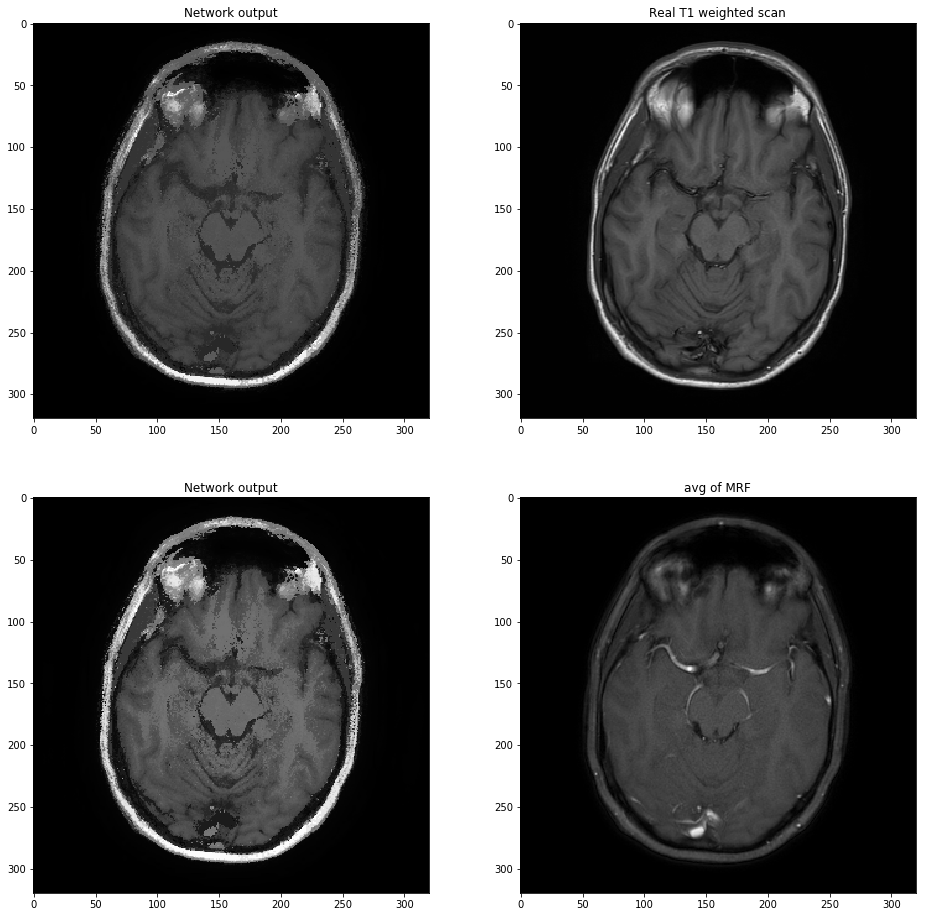

In [30]:
fig = plt.figure(figsize=(16,16))
print("alpha 0")
plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(T1_test, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(MRF_avg, cmap="gray",vmin=0,vmax=255)

plt.show()

In [31]:
print(np.sqrt(mse(T1_recon, T1_test)))
print(np.sqrt(mse(MRF_avg, T1_test)))

18.030229670731003
6.285227285568121


In [33]:
print(ssim(T1_recon, T1_test))
print(ssim(MRF_avg, T1_test))

0.7364291801255641
0.6751087022078037
